# Part 1 — Rock Performers Network Analysis (LWCC)

**Goal:** Present a concise, self-contained analysis of the network of bands/artists built from Wikipedia links (largest weakly connected component, LWCC). Use tools from **Lecture 5** (week5.py) and basic network measures (e.g., degree distribution from week4) to characterize the network for an audience that knows network science but not this specific network.

**Focus topics (not exhaustive):**
- Network summary and degree distribution (baseline).
- Centrality (degree + one advanced centrality).
- Degree/attribute assortativity.
- A **network backbone** (k-core) to focus on the dense core.
- At least one **network visualization** (ForceAtlas2 on the backbone).

We deliberately **avoid an exhaustive dump**. Instead we select a few informative measures/plots and explain what they say about this network.


### Overview of our analytical approach

We approached this analysis by first identifying the most meaningful ways to describe the structure of the rock performers network without overwhelming the reader with redundant metrics. We decided to begin with fundamental properties such as the degree distribution to establish the network’s overall connectivity pattern. Building on this baseline, we examined centrality measures—degree and betweenness—to highlight key artists that act as either hubs or bridges. We then explored assortativity to understand whether highly connected or content-rich nodes tend to link with similar ones, providing insights into homophily and hierarchical tendencies in the network. Finally, to visualize and summarize the dense structural core, we extracted a network backbone using k-core decomposition and plotted it using a ForceAtlas2 layout. Throughout, we balanced completeness with interpretability, focusing on measures that best convey the character and organization of the rock performer network.


In [1]:
# Imports & reproducibility
import math
import pickle
import warnings
from collections import Counter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Reproducibility: control randomness in layouts and sampling
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plot settings
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 150

# Make warnings less noisy in notebook output
warnings.filterwarnings("ignore", category=UserWarning)

def safe_forceatlas2_layout(G, seed=RANDOM_SEED, **kwargs):
    """
    Try to use NetworkX's ForceAtlas2 layout (NX >= 3.5).
    If not available, fall back to spring_layout with a fixed seed.
    """
    if hasattr(nx, "forceatlas2_layout"):
        return nx.forceatlas2_layout(G, seed=seed, **kwargs)
    # Fallback (still deterministic via seed)
    return nx.spring_layout(G, seed=seed, k=None, iterations=300)

def alias_content_length_attributes(G):
    """
    Some course notebooks used 'content_length' while others used 'length_of_content'.
    Create a consistent 'length_of_content' attribute for all nodes.
    """
    for n, data in G.nodes(data=True):
        if "length_of_content" not in data:
            data["length_of_content"] = data.get("content_length", 0)



## Data — Load the LWCC graph

We load the **largest weakly connected component** of the Wikipedia rock performers graph (`rock_performers_LWCC.gpickle`). If the file is not present locally, we download it from the provided GitHub RAW URL.


In [ ]:
import os, requests

RAW_GPICKLE_URL = (
    "https://raw.githubusercontent.com/LeoItaly/02805-social-graphs-interactions/main/Assignment%201/rock_performers_LWCC.gpickle"
)

local_path = "rock_performers_LWCC.gpickle"

if not os.path.exists(local_path):
    print("Downloading LWCC gpickle from GitHub ...")
    resp = requests.get(RAW_GPICKLE_URL, timeout=30)
    resp.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(resp.content)
    print("Saved:", local_path)

# Load with pickle for maximum compatibility
with open(local_path, "rb") as f:
    H = pickle.load(f)

print(
    f"Loaded H (directed): {H.number_of_nodes()} nodes, "
    f"{H.number_of_edges()} edges, directed={H.is_directed()}"
)

Saved: rock_performers_LWCC.gpickle
Loaded H (directed): 483 nodes, 7587 edges, directed=True



## Undirected GCC used for structure

For degree distribution, assortativity, and the visualization we work on the **undirected** giant connected component.


In [ ]:
# Undirected GCC
G_und = H.to_undirected()
gcc_nodes = max(nx.connected_components(G_und), key=len)
G = G_und.subgraph(gcc_nodes).copy()

alias_content_length_attributes(G)

print(f"Undirected GCC: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Undirected GCC: 483 nodes, 6299 edges


## Degree distribution (baseline)

A basic fingerprint of the network. We summarize the (undirected) degree distribution and plot counts in log-log axes.

Average degree: 26.08
Median degree : 20
Max degree    : 356


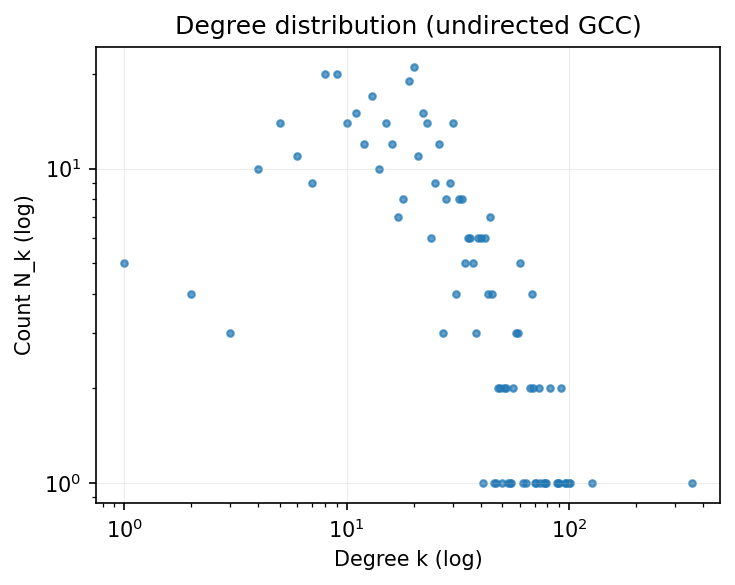

In [ ]:
deg = dict(G.degree())
deg_vals = np.array(list(deg.values()))

# Summary stats
print(f"Average degree: {deg_vals.mean():.2f}")
print(f"Median degree : {np.median(deg_vals):.0f}")
print(f"Max degree    : {deg_vals.max():.0f}")

# Degree histogram on log-log
deg_count = Counter(deg_vals)
xs = np.array(sorted(deg_count.keys()))
ys = np.array([deg_count[x] for x in xs])

fig, ax = plt.subplots(figsize=(5.0, 4.0))
ax.scatter(xs, ys, s=10, alpha=0.7)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Degree k (log)")
ax.set_ylabel("Count N_k (log)")
ax.set_title("Degree distribution (undirected GCC)")
ax.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout(); plt.show()

The degree distribution of the rock performers network is clearly **right-skewed and heavy-tailed**.  
Most artists have relatively few connections—around 20 links on average (median degree = 20)—while a small minority of highly connected artists form hubs (maximum degree = 356).  
The approximate mean degree of 26.1 confirms that although the network is fairly well connected overall, connectivity is extremely uneven.  
This long-tail pattern suggests **preferential attachment–like dynamics**, where popular or historically influential artists accumulate disproportionately many links.  
Such structural heterogeneity provides motivation to explore **centrality measures** (to identify those key hubs and bridges) and **assortativity** (to see whether these high-degree nodes tend to connect with one another or with less connected artists).

## Centrality

We report nodes with high **degree centrality** (connectivity) and **betweenness centrality** (control of shortest paths). Betweenness is approximated for large graphs by sampling sources when needed.

In [5]:
# Degree centrality on the directed H (total in+out normalized by N-1)
deg_cent = nx.degree_centrality(H)

def topk_items(d, k=10):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

print("Top-10 by degree centrality (directed total):")
for n, v in topk_items(deg_cent, 10):
    print(f"{v:.4f}  {n}")

Top-10 by degree centrality (directed total):
0.7407  AllMusic
0.3071  Led_Zeppelin
0.2780  Black_Sabbath
0.2759  Queen_(band)
0.2739  Metallica
0.2614  Bob_Dylan
0.2593  Alice_in_Chains
0.2531  Deep_Purple
0.2365  Guns_N'_Roses
0.2261  Jimi_Hendrix


In [6]:
# Betweenness centrality (approximate if N large)
N = H.number_of_nodes()
if N <= 3000:
    btw = nx.betweenness_centrality(H, normalized=True)
else:
    # Sample sources for speed; reproducible via seed
    k = min(300, N)
    rng = np.random.default_rng(RANDOM_SEED)
    sources = rng.choice(list(H.nodes()), size=k, replace=False)
    btw = nx.betweenness_centrality(H, k=k, normalized=True, seed=RANDOM_SEED)

print("\nTop-10 by betweenness centrality (directed):")
for n, v in topk_items(btw, 10):
    print(f"{v:.5f}  {n}")


Top-10 by betweenness centrality (directed):
0.04303  Deep_Purple
0.03866  Queen_(band)
0.03668  Alice_in_Chains
0.03528  Guns_N'_Roses
0.03435  Led_Zeppelin
0.03258  Jimi_Hendrix
0.03213  Black_Sabbath
0.02881  Bob_Dylan
0.02661  Little_Richard
0.02503  Metallica


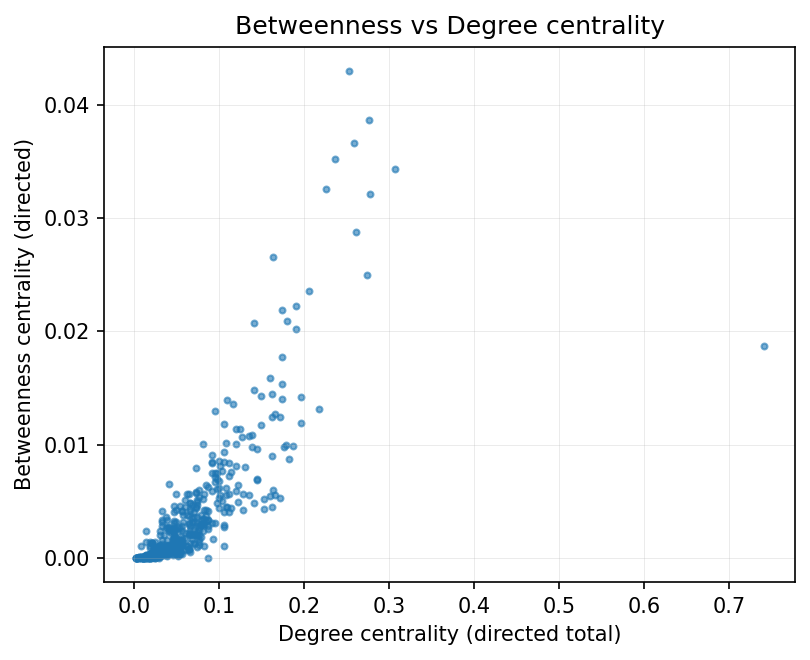

In [7]:
# Relationship: betweenness vs degree centrality (scatter)
deg_arr = np.array([deg_cent[n] for n in H.nodes()])
btw_arr = np.array([btw.get(n, 0.0) for n in H.nodes()])

fig, ax = plt.subplots(figsize=(5.5, 4.5))
ax.scatter(deg_arr, btw_arr, s=8, alpha=0.6)
ax.set_xlabel("Degree centrality (directed total)")
ax.set_ylabel("Betweenness centrality (directed)")
ax.set_title("Betweenness vs Degree centrality")
ax.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout(); plt.show()

**Figure commentary.**  
The scatterplot shows a clear **positive correlation** between degree and betweenness centrality: artists with many connections tend to also play an important intermediary role in the flow of links.  
However, the relationship is not perfectly linear. Most nodes cluster near the origin, indicating a majority of artists with both low degree and low betweenness, while a few nodes rise sharply above the cloud—these represent artists that act as **structural bridges** between otherwise loosely connected parts of the network.  
Interestingly, one node with exceptionally high degree centrality (above 0.6) show relatively modest betweenness, suggesting that the most connected hubs are embedded within densely linked communities rather than serving as cross-community brokers.  
Overall, the network’s topology suggests a combination of **hub dominance** and **localized bridging**.

## Assortativity

We quantify mixing by **degree** and by the node attribute **`length_of_content`** (Wikipedia page length).

In [8]:
# Degree assortativity (undirected GCC)
deg_r = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity (undirected GCC): r = {deg_r:.3f}")

# Attribute assortativity for page length (numeric)
len_num_r = nx.numeric_assortativity_coefficient(G, "length_of_content")
print(f"Numeric assortativity (length_of_content): r = {len_num_r:.3f}")

# Optional categorical view: quartile binning of page length
lengths = np.array([G.nodes[n]["length_of_content"] for n in G.nodes()])
q25, q50, q75 = np.quantile(lengths, [0.25, 0.5, 0.75])
def len_bin(v):
    return 0 if v <= q25 else 1 if v <= q50 else 2 if v <= q75 else 3

for n in G.nodes():
    G.nodes[n]["len_bin"] = len_bin(G.nodes[n]["length_of_content"])

len_cat_r = nx.attribute_assortativity_coefficient(G, "len_bin")
print(f"Categorical assortativity (len_bin quartiles): r = {len_cat_r:.3f}")

Degree assortativity (undirected GCC): r = -0.091
Numeric assortativity (length_of_content): r = 0.068
Categorical assortativity (len_bin quartiles): r = 0.031


**Interpretation.**  
The network shows a **slightly negative degree assortativity** (r = –0.091), indicating a weakly **disassortative** structure where highly connected artists tend to link with less connected ones rather than with other hubs.  
This hub–periphery tendency is typical of information networks, where a few central entities connect to many smaller nodes.  

The **numeric assortativity for page length** (r = 0.068) is mildly positive, suggesting that artists with longer Wikipedia pages tend to connect somewhat more often with others who also have long pages—possibly reflecting popularity or historical significance.  
Similarly, the **categorical assortativity based on page-length quartiles** (r = 0.031) reinforces that this effect is very weak.  

Overall, the results imply that while the network’s topology is shaped by hub–periphery organization, **content-related similarity (page length)** plays only a minimal role in link formation.


## Network backbone: k-core

To focus on the densely interlinked **core**, we extract the highest non-empty **k-core** of the undirected GCC. The k-core keeps nodes whose degree within the subgraph is at least *k*, peeling away the periphery and isolating the structural heart of the network.


In [9]:
core_num = nx.core_number(G)
k_max = max(core_num.values())

# Highest non-empty core
core_nodes = [n for n, k in core_num.items() if k == k_max]
G_core = G.subgraph(core_nodes).copy()

print(f"Max core number: k_max = {k_max}")
print(f"k-core size   : {G_core.number_of_nodes()} nodes, {G_core.number_of_edges()} edges")

# If the top core is very small, drop to the next level to make a nicer plot
if G_core.number_of_nodes() < 50 and k_max > 1:
    target_k = k_max - 1
    core_nodes = [n for n, k in core_num.items() if k == target_k]
    G_core = G.subgraph(core_nodes).copy()
    print(f"Using k={target_k} for visualization: {G_core.number_of_nodes()} nodes")

Max core number: k_max = 19
k-core size   : 139 nodes, 2180 edges



## Visualization: Backbone (k-core) with ForceAtlas2

We plot the k-core backbone with **ForceAtlas2** (or a spring-layout fallback).  
- **Node size:** betweenness centrality (from the directed graph `H`).
- **Node color:** `length_of_content` (page length).  
- Labeled: a few nodes with the largest betweenness scores.


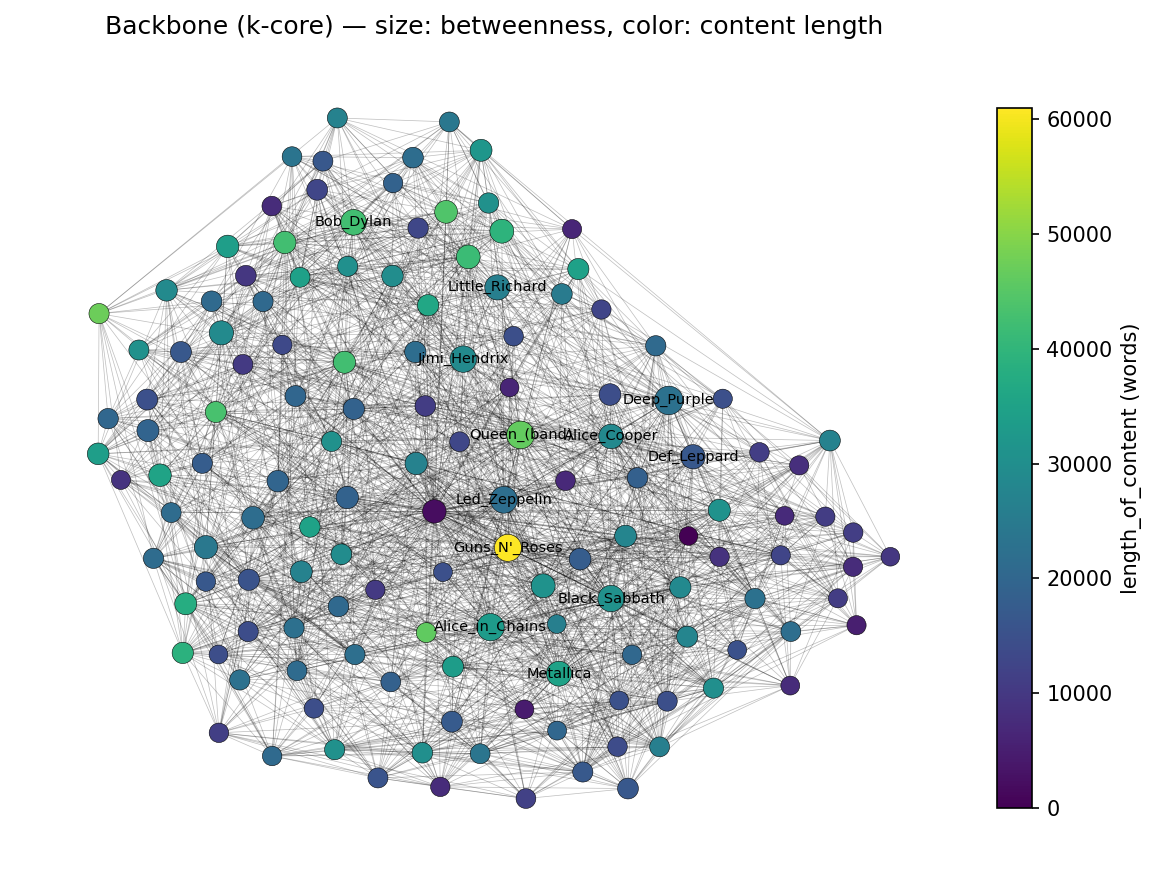

In [10]:
# Prepare sizes by betweenness (map from H to G_core; zeros if missing)
btw_scores = {n: btw.get(n, 0.0) for n in G_core.nodes()}
sizes = np.array([80 + 2500*btw_scores[n] for n in G_core.nodes()])

# Colors by content length
content = np.array([G_core.nodes[v].get("length_of_content", 0) for v in G_core.nodes()])

pos = safe_forceatlas2_layout(
    G_core,
    max_iter=800,
    dissuade_hubs=True,
    scaling_ratio=2.5,
    gravity=1.0,
)

fig, ax = plt.subplots(figsize=(8, 6))
nx.draw_networkx_edges(G_core, pos, ax=ax, width=0.35, alpha=0.25)
nodes = nx.draw_networkx_nodes(
    G_core, pos, ax=ax,
    node_size=sizes,
    node_color=content,
    cmap="viridis",
    linewidths=0.25, edgecolors="black"
)

# Colorbar for page length
cbar = plt.colorbar(nodes, ax=ax, shrink=0.85, pad=0.02)
cbar.set_label("length_of_content (words)")

# Label a handful of top-betweenness nodes
topk_labels = sorted(btw_scores, key=btw_scores.get, reverse=True)[:12]
nx.draw_networkx_labels(G_core, pos, labels={n:n for n in topk_labels}, font_size=7)

ax.set_title("Backbone (k-core) — size: betweenness, color: content length")
ax.axis("off")
plt.tight_layout(); plt.show()

**Figure commentary.**  
The k-core backbone highlights a densely connected core of prominent rock artists where structural and cultural centrality converge.  
A few artists—such as **Guns N’ Roses**, **Led Zeppelin**, **Queen**, and **Metallica**—stand out with larger node sizes, reflecting high betweenness scores that mark them as key bridges between sub-scenes.  
The color scale, representing Wikipedia page length, shows that many of these central acts also have longer, more comprehensive pages (yellow-green hues), indicating their historical importance and widespread recognition.  
Peripheral nodes, often representing niche or era-specific bands, display shorter pages and lower betweenness, forming small local clusters around major hubs.  
Overall, the backbone visualization confirms that the rock performer network has a **highly cohesive core** dominated by influential, well-documented artists, while smaller clusters attach around these central figures—consistent with a **hub-and-community** organization typical of cultural collaboration networks.


## Finale thoughts

- The network is **highly heterogeneous**, with a heavy-tailed degree distribution (average degree ≈ 26, max = 356) indicating a small number of extremely well-connected hubs amid many modestly connected artists.  
- **Central roles** are divided between high-degree connectors, embedded within dense clusters, and **high-betweenness brokers** that bridge stylistic or temporal sub-scenes.  
- The network exhibits **slight disassortativity** (r ≈ –0.09), meaning hubs tend to connect to less-connected artists; meanwhile, **content-based assortativity** (r ≈ 0.03–0.07) is weak, suggesting only minimal similarity mixing by Wikipedia page length.  
- The **k-core backbone** reveals a cohesive structural core dominated by historically significant artists (e.g., *Queen*, *Led Zeppelin*, *Guns N’ Roses*, *Metallica*), surrounded by smaller clusters that represent stylistic or generational communities.  
- Overall, the rock performer network combines **hub-and-spoke topology** with localized community structure, reflecting both popularity-driven attachment and enduring cultural clustering.



## References

- Week 4 (network construction; LWCC; basic stats).  
- Week 5 (advanced measures; ForceAtlas2; centrality & assortativity).  
- NetworkX Drawing reference (for plotting helpers).  
- Barabási, *Network Science*, Ch. 2–5 & 9 (background on degree, small worlds, growth, and meso-scale structure).

## Contribution 

> Leo s240094: part 1. 

> Fran 

> Julia 